### Title: A Machine Learning Approach to Email Spam Detection

In this project, we aim to develop a machine learning algorithm to accurately classify emails as either spam or legitimate (ham). The increase in email usage has led to a surge in spam emails, which can be both annoying and harmful. We aim to create a robust spam detection system that helps users filter out unwanted messages and maintain a clean inbox. We are using a [Spam email classification Dataset from kaggle.com](https://www.kaggle.com/datasets/ashfakyeafi/spam-email-classification) with a total of 5,574 unique and legitimate email messages downloaded from the Kaggle website.

**Objectives:**

0. Data Collection: At this stage, I will gather raw data from various sources such as surveys, databases, or web scraping to compile a dataset that is representative of the problem at hand.

1. Data Preprocessing: During this phase, I will clean and transform the raw data to prepare it for analysis. This involves tasks like handling missing values, normalizing data, encoding categorical variables, and removing any irrelevant information.

2. Feature Engineering: Here, I will focus on creating and modifying features to boost the model’s performance. This includes selecting key features, generating new ones, and applying transformations to improve the model's effectiveness.

3. Data Visualization: In this part, I will develop graphical representations of the data to uncover patterns, trends, and insights. This helps in understanding the data better and communicating findings more clearly.

4. Modeling: At this step, I will apply statistical or machine learning algorithms to the prepared data to build predictive or descriptive models. This includes choosing the right algorithms, training the models, and assessing their performance.

5. Model Selection: During this phase, I will evaluate and choose the best model from a set of candidates based on their performance metrics. This involves comparing models, fine-tuning hyperparameters, and ensuring the model’s accuracy through techniques like cross-validation.

6. App Documentation: Finally, I will produce comprehensive documentation for the application. This includes providing user instructions, detailing technical aspects of the data and models, commenting on the code, and offering installation and setup guidelines.

**Expected Outcomes:**
* A high-accuracy email spam classification model.
* An efficient preprocessing and feature extraction pipeline.
* A user-friendly interface for real-time spam detection.
* Improved email management and reduced risk from spam emails for users.

By the end of this project, we aim to provide a reliable and efficient solution to the email spam problem, enhancing the user experience and security of email communication.


#### 0. Data collection:

In [58]:
# Importing the libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [59]:
# Importing the dataset
df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### 1. Data Preprocessing

In [61]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [62]:
# Count of duplicated rows
df.duplicated().sum()

415

> There are 415 duplicated rows to drop.

In [63]:
#removing duplicates
df = df.drop_duplicates()
df.shape

(5158, 2)

> At this point I would like to understand better the features and the dataset in overall by plotting a few Graphs.
I would like to start by checking whether the dataset is balanced or not in terms of the outcome variable `spam`.

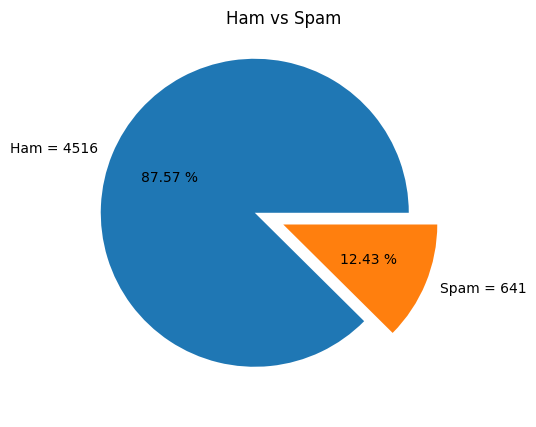

In [64]:
# Creating a Pie chart for spam and ham

number_of_spam = df[df['Category'] == 'spam'].shape[0]
number_of_ham = df[df['Category'] == 'ham'].shape[0]

plt.figure(figsize=(6,5))

mail_categories = [number_of_ham, number_of_spam]
labels = [f"Ham = {number_of_ham}", f"Spam = {number_of_spam}"]
explode = [.2, 0]

plt.pie(mail_categories, labels=labels, explode=explode, autopct="%.2f %%")
plt.title("Ham vs Spam")

plt.show()

> The previous pie chart shows that the majority class (Ham) has over 8 times more samples than the minority class (Spam). This imbalance can be problematic for some machine learning models, as they might prioritize learning patterns from the majority class and overlook the minority class. To address this problem we are using **undersampling** reducing the number of examples from the majority class (Ham) to match the size of the minority class.

In [65]:
# Undersampling the ham data
spam = df[df['Category'] == 'spam']
ham = df[df['Category'] == 'ham']

ham_under = ham.sample(spam.shape[0])
df_under = pd.concat([ham_under, spam], axis=0)

df = df_under

df['Category'].value_counts()

Category
ham     641
spam    641
Name: count, dtype: int64

> Now, nest step is to remove punctuation. Text data can vary widely in terms of punctuation usage. Removing punctuation can help standardize the text, making it easier to process and analyze. For instance, "Hello!" and "Hello" would be treated as the same after removing punctuation. Punctuation marks often do not carry semantic meaning and can introduce noise into text data. By removing them, you focus on the actual words, which are typically more important for tasks like sentiment analysis, text classification, or keyword extraction.

In [66]:
# Removing punctuation
import string
string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Message'] = df['Message'].apply(remove_punctuation)
df.head()

,Category,Message
4369,ham,1 I dont have her number and 2 its gonna be a ...
1661,ham,No just send to you Bec you in temple na
1454,ham,Stupidits not possible
2116,ham,Well I wasnt available as I washob nobbing wit...
1179,ham,Im outside islands head towards hard rock and ...


#### 2. Feature Engineering

> Following data cleaning, we proceed to feature engineering. The initial step entails encoding the 'spam' feature using scikit-learn's LabelEncoder class.

In [67]:
# Using sci-kit learn to label encode the spam column

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df.tail()

,Category,Message
5537,1,Want explicit SEX in 30 secs Ring 02073162414 ...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths Latest Motor...
5566,1,REMINDER FROM O2 To get 250 pounds free call c...
5567,1,This is the 2nd time we have tried 2 contact u...


> To enrich the model's feature set, we can introduce two additional numerical features: word count and message length. 

* `Lenght:` This feature represents the number of characters in the message.
* `Words:` This feature represents the number of words in the message.

In [68]:
# Column to represent the length of the text

df['length'] = df['Message'].apply(len)
df.head()

,Category,Message,length
4369,0,1 I dont have her number and 2 its gonna be a ...,118
1661,0,No just send to you Bec you in temple na,40
1454,0,Stupidits not possible,22
2116,0,Well I wasnt available as I washob nobbing wit...,104
1179,0,Im outside islands head towards hard rock and ...,63


In [69]:
# Column with the number of words

def count_words(text):
    return len(text.split())

df['words'] = df['Message'].apply(count_words)
df.head()

,Category,Message,length,words
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26
1661,0,No just send to you Bec you in temple na,40,10
1454,0,Stupidits not possible,22,3
2116,0,Well I wasnt available as I washob nobbing wit...,104,21
1179,0,Im outside islands head towards hard rock and ...,63,12


**Word tokenization:**

> Word tokenization, in the context of Natural Language Processing (NLP), is the process of splitting a piece of text into smaller units called tokens. The tokenizer splits the text based on predefined rules or delimiters. The most common delimiter is a whitespace character (space, tab, newline, etc.), resulting in individual words as tokens.

In [70]:
import nltk
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources (do this only once)
nltk.download('punkt')

def tokenize_text_nltk(text):
  # Lowercase the text
  text = text.lower()
  # Tokenize using NLTK word_tokenize
  tokens = word_tokenize(text)
  return tokens

df['tokens_nltk'] = df['Message'].apply(tokenize_text_nltk)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Category,Message,length,words,tokens_nltk
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, i, dont, have, her, number, and, 2, its, g..."
1661,0,No just send to you Bec you in temple na,40,10,"[no, just, send, to, you, bec, you, in, temple..."
1454,0,Stupidits not possible,22,3,"[stupidits, not, possible]"
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, i, wasnt, available, as, i, washob, nob..."
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro..."


**Removing Stop Words:**

> In Natural Language Processing (NLP), removing stop words is a technique where you eliminate frequently occurring, generic words from your text data. These stop words typically don't contribute much to the core meaning of a sentence and can even add noise to your analysis.

In [71]:
# removing stopwords

from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]

df['tokens_nltk'] = df['tokens_nltk'].apply(remove_stopwords)

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Message,length,words,tokens_nltk
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, dont, number, 2, gon, na, massive, pain, a..."
1661,0,No just send to you Bec you in temple na,40,10,"[send, bec, temple, na]"
1454,0,Stupidits not possible,22,3,"[stupidits, possible]"
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, wasnt, available, washob, nobbing, last..."
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro..."


> Now let's add a new column to count the number of words after having removed the stop words.

In [72]:
# Column with the number of words for nltk tokens

def count_words_nltk(tokens):
    return len(tokens)

df['words_nltk'] = df['tokens_nltk'].apply(count_words_nltk)
df.head()

,Category,Message,length,words,tokens_nltk,words_nltk
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, dont, number, 2, gon, na, massive, pain, a...",15
1661,0,No just send to you Bec you in temple na,40,10,"[send, bec, temple, na]",4
1454,0,Stupidits not possible,22,3,"[stupidits, possible]",2
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, wasnt, available, washob, nobbing, last...",11
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro...",9


> Note that the number of words decreased so we now have a cleaner text message.

Now, another thechnique we can use is Stemming or Lemmatization.

**Stemming/Lemmatization:** 
> While Stemming reduces words to their base form (e.g., "running" becomes "run"), Lemmatization uses a dictionary and morphological analysis to map a word to its base form, called a lemma. It considers the part of speech of the word and aims to identify the canonical form used in the dictionary. Lemmatization goes a step further, considering the part of speech (e.g., "better" becomes "good").  
In this step, we will use `Lemmatization`.

In [73]:
# Stemming/Lemmatization: using NLTK
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() 

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

df['lemmatized'] = df['tokens_nltk'].apply(lemmatize_text)

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, dont, number, 2, gon, na, massive, pain, a...",15,"[1, dont, number, 2, gon, na, massive, pain, a..."
1661,0,No just send to you Bec you in temple na,40,10,"[send, bec, temple, na]",4,"[send, bec, temple, na]"
1454,0,Stupidits not possible,22,3,"[stupidits, possible]",2,"[stupidits, possible]"
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, wasnt, available, washob, nobbing, last...",11,"[well, wasnt, available, washob, nobbing, last..."
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro...",9,"[im, outside, island, head, towards, hard, roc..."


#### 3. Data vizualization

In [74]:
# Convert lemmatized tokens back to text before plotting word cloud
def tokens_to_text(tokens):
    return ' '.join(tokens)
df['lemmatized_text'] = df['lemmatized'].apply(tokens_to_text)
df.head()

,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized,lemmatized_text
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, dont, number, 2, gon, na, massive, pain, a...",15,"[1, dont, number, 2, gon, na, massive, pain, a...",1 dont number 2 gon na massive pain as id rath...
1661,0,No just send to you Bec you in temple na,40,10,"[send, bec, temple, na]",4,"[send, bec, temple, na]",send bec temple na
1454,0,Stupidits not possible,22,3,"[stupidits, possible]",2,"[stupidits, possible]",stupidits possible
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, wasnt, available, washob, nobbing, last...",11,"[well, wasnt, available, washob, nobbing, last...",well wasnt available washob nobbing last night...
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro...",9,"[im, outside, island, head, towards, hard, roc...",im outside island head towards hard rock youll...


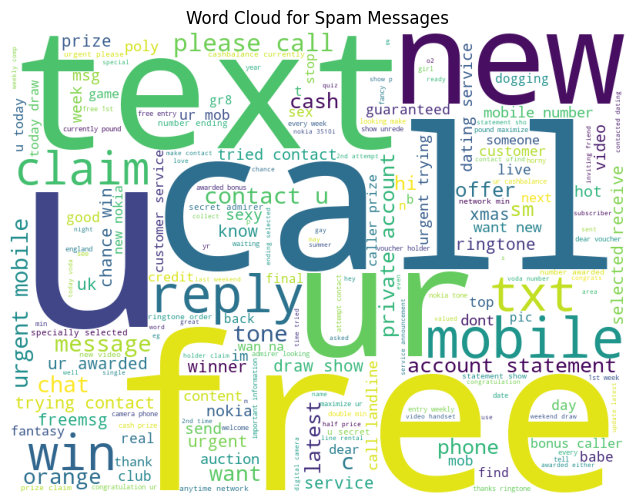

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtering the spam messages
df_spam = df[df['Category'] == 1]

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, background_color="white")

# Generate the word cloud
wordcloud.generate(df_spam['lemmatized_text'].to_string())

# Create a figure and display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Spam Messages")
plt.show()

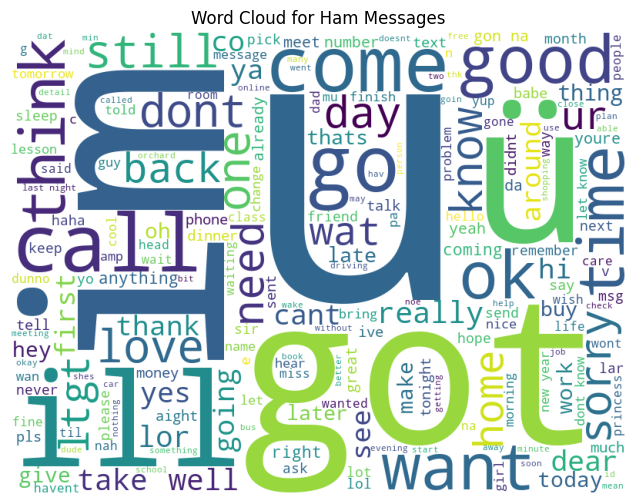

In [76]:
# Filtering the ham messages
df_ham = df[df['Category'] == 0]

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, background_color="white")

# Generate the word cloud
wordcloud.generate(df_ham['lemmatized_text'].to_string())

# Create a figure and display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Ham Messages")
plt.show()

> **N-grams:**  
> This sptep allow us to create sequences of n words called Bigrams (2 words) and trigrams (3 words). These N-grams can capture word relationships that single words might miss.

> Single Words vs. Sequences: Individual words might not always convey the full meaning on their own. Bigrams (two-word sequences) and trigrams (three-word sequences) can capture the relationships between words, which can be crucial for tasks like:
> * Sentiment Analysis: "not good" vs. "very good" expresses a clear difference in sentiment.
> * Topic Modeling: Identifying bigrams like "machine learning" or trigrams like "natural language processing" can help identify topics within text data.
> * Machine Translation: Capturing word order and phrasal meaning is essential for accurate translation.

In [77]:
# N-grams (bigrams and trigrams)
from nltk.util import ngrams

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

df['bigrams'] = df['lemmatized'].apply(lambda x: extract_ngrams(x, 2))
df['trigrams'] = df['lemmatized'].apply(lambda x: extract_ngrams(x, 3))

df.head()

,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized,lemmatized_text,bigrams,trigrams
4369,0,1 I dont have her number and 2 its gonna be a ...,118,26,"[1, dont, number, 2, gon, na, massive, pain, a...",15,"[1, dont, number, 2, gon, na, massive, pain, a...",1 dont number 2 gon na massive pain as id rath...,"[(1, dont), (dont, number), (number, 2), (2, g...","[(1, dont, number), (dont, number, 2), (number..."
1661,0,No just send to you Bec you in temple na,40,10,"[send, bec, temple, na]",4,"[send, bec, temple, na]",send bec temple na,"[(send, bec), (bec, temple), (temple, na)]","[(send, bec, temple), (bec, temple, na)]"
1454,0,Stupidits not possible,22,3,"[stupidits, possible]",2,"[stupidits, possible]",stupidits possible,"[(stupidits, possible)]",[]
2116,0,Well I wasnt available as I washob nobbing wit...,104,21,"[well, wasnt, available, washob, nobbing, last...",11,"[well, wasnt, available, washob, nobbing, last...",well wasnt available washob nobbing last night...,"[(well, wasnt), (wasnt, available), (available...","[(well, wasnt, available), (wasnt, available, ..."
1179,0,Im outside islands head towards hard rock and ...,63,12,"[im, outside, islands, head, towards, hard, ro...",9,"[im, outside, island, head, towards, hard, roc...",im outside island head towards hard rock youll...,"[(im, outside), (outside, island), (island, he...","[(im, outside, island), (outside, island, head..."


> Now we need to convert our text message into a numerical representation suitable for machine learning algorithms, an we have to options:
> * TF-IDF: If you want to emphasize the importance of words that are frequent within a document but rare across the corpus (potentially good indicators of spam), TF-IDF might be a better choice.
> * BoW: If a simple word count representation is sufficient for your task, BoW might be a more efficient option.

To potentially improve the accuracy of our spam/ham classification model, we can now incorporate TF-IDF **(Term Frequency-Inverse Document Frequency)**. This technique assigns weights to words based on their frequency within a document and rarity across the entire corpus, potentially highlighting terms that are more indicative of spam text message.

In [78]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer
vectorizer.fit(df['lemmatized_text'])

# Transform the text to a TF-IDF vector
X_tfidf = vectorizer.transform(df['lemmatized_text'])

> **Convert bigrams/trigrams** lists into numerical representations:  

> Use `CountVectorizer` to create a sparse matrix where each row is a message and columns represent unique bigrams/trigrams with their counts.

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

def custom_preprocessor(text):
    # Customize preprocessing for lists (e.g., join with a special character)
    return ' '.join(['_'.join(bigram) for bigram in text])


vectorizer_bigrams = CountVectorizer(preprocessor=custom_preprocessor)
vectorizer_bigrams.fit_transform(df['bigrams'])
X_bigrams = vectorizer_bigrams.transform(df['bigrams'])


vectorizer_trigrams = CountVectorizer(preprocessor=custom_preprocessor)
vectorizer_trigrams.fit_transform(df['trigrams'])
X_trigrams = vectorizer_trigrams.transform(df['trigrams'])

> Concatenate these features into a single DataFrame or NumPy array for training your mode

#### 4. Modeling

##### Splitting the data

> Now I will split the data into features/target variable and training and test sets. To do so, we will apply feature `hashing` to bigrams/trigrams for a fixed-size vector representation.

In [80]:
from scipy.sparse import hstack

# Combine the sparse matrices
X_combined = hstack((X_tfidf, X_bigrams, X_trigrams))

y = df['Category']

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


##### **Random forest**

I will start by using `GridSearchCV` to tune a random forest model using parameter as follows:

 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

For this case I will set `refit` to `'f1'` given that:

In this case:

 - Accuracy might be high if the model mostly predicts non-churn (majority class), even if it misses many actual churners (minority class).
 - Precision is valuable to ensure customers flagged as likely to churn actually do churn, minimizing unnecessary interventions.
 - Recall is crucial to identify as many churners as possible, even if it means some false positives (non-churners predicted as churn).
 - F1-score provides a balance between precision and recall, giving a more holistic view of churn prediction performance.

In [82]:
# 1. Instantiate the random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             'class_weight': ['balanced_subsample', 'balanced'],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [83]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 1min 45s
Wall time: 6min 29s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced_subsample', 'balanced'],
                         'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [84]:
# Examine best score
rf_cv.best_score_

0.8721374045801527

> Examine the best combination of hyperparameters.

In [85]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [86]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'accuracy': [accuracy],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [87]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,accuracy,precision,recall,F1
0,RF cv,0.897537,0.923907,0.872137,0.896924


##### **XGBoost**

As in Desicion Treen I will be using `GridSearchCV` to tune a random forest model using parameter as follows:

 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

For this case I will also set `refit` to `'f1'` because of the resons I mentioned before.

In [88]:
# 1. Instantiate the XGBoost classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=10)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300],
             'scale_pos_weight': [5, 10],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [89]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 33min 56s
Wall time: 7min 5s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300],
                         'scale_pos_weight': [5, 10]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [90]:
# Examine best score
xgb_cv.best_score_

0.9961832061068703

In [91]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300,
 'scale_pos_weight': 10}

In [92]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.897537,0.923907,0.872137,0.896924
0,XGB cv,0.583414,0.551250,0.996183,0.709734


#### 5. Model Selection

Now, I will use the best random forest model and the best XGBoost model to predict on the test data. Whichever performs better will be selected as the champion model.

##### Random Forest

In [93]:
# Use random forest model to predict on test data
rf_test_preds = rf_cv.best_estimator_.predict(X_test)

> The next function will help to generate a table with the scores from the predictions made

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [95]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF Test', rf_test_preds, y_test)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.897537,0.923907,0.872137,0.896924
0,XGB cv,0.583414,0.551250,0.996183,0.709734
0,RF Test,0.891051,0.900901,0.854701,0.877193


##### XGBoost Classifier

In [96]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.897537,0.923907,0.872137,0.896924
0,XGB cv,0.583414,0.551250,0.996183,0.709734
0,RF Test,0.891051,0.900901,0.854701,0.877193
0,XGB test,0.536965,0.495690,0.982906,0.659026


> Noticed that the Champion Model here is the `Random Forest Classifier` given that the final scores indicate that performed better

> **Random Forest Model Performance:**

> * Accuracy (0.891051): This is a high overall accuracy, exceeding 89%, indicating the model effectively classified most emails in the test set.
> * Precision (0.900901): The precision suggests that out of every 10 emails classified as spam, around 9.0 were actual spam, while the remaining 1.0 were ham emails mistakenly classified as spam (False Positives).
> * Recall (0.854701): This value is slightly lower than the XGBoost model's recall, indicating the XGBoost model captured a larger proportion (nearly 100%) of the actual spam emails in the test set. This means it missed a smaller percentage of spam emails compared to the Random Forest model.
> * F1-Score (0.877193): The F1-score suggests a good balance between precision and recall.

##### Use champion model to predict on test data

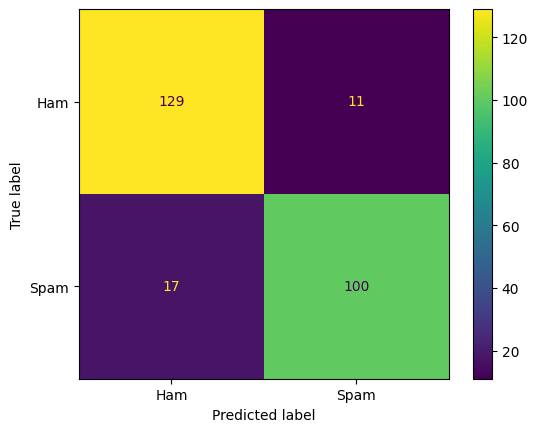

In [97]:
# Use Random Forest model to predict on test data
champion_preds= rf_cv.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, champion_preds, labels=rf_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Ham', 'Spam'])
disp.plot();

# Save the model to disk
filename = 'rf_model.pkl'
pickle.dump(rf_cv.best_estimator_, open(filename, 'wb'))

**Values in the Matrix:**

Cell (0, 0): True Positive (TP) - Number of correctly classified spam text message.  
Cell (0, 1): False Negative (FN) - Number of spam text message incorrectly classified as ham.  
Cell (1, 0): False Positive (FP) - Number of ham text message incorrectly classified as spam.  
Cell (1, 1): True Negative (TN) - Number of correctly classified ham text message.  

**Conclusion:**

* High TP and Low FP: The model effectively identifies **129** Ham text message with minimal **17** false positives (correctly classifying most actual Ham).
* High TN and Low FN: The model accurately classifies **100** Spam text message, avoiding **11** false negatives (missing very little actual spam).

> I will save it the model using `Pickle` library.

In [98]:
# Save the model to disk

filename = 'rf_model.pkl'
pickle.dump(rf_cv.best_estimator_, open(filename, 'wb'))


> And also the vectorizers

In [99]:
import pickle

# Assuming your vectorizers are named as follows
with open('vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('vectorizer_bigrams.pkl', 'wb') as f:
    pickle.dump(vectorizer_bigrams, f)
with open('vectorizer_trigrams.pkl', 'wb') as f:
    pickle.dump(vectorizer_trigrams, f)


#### Streamlit app documentation

Spam/Ham Message Classifier Streamlit App
Overview
This Streamlit app is designed to classify text messages as either "Spam" or "Ham" using a trained machine learning model. The model, along with necessary vectorizers, can be loaded either from local files or directly from GitHub.

**Dependencies**
The app requires the following Python libraries:
*	streamlit: For building the web application interface.
*	pickle: For loading serialized model and vectorizer files.
*	string: For text processing tasks.
*	nltk: For natural language processing (tokenization, stopwords removal, lemmatization).
*	sklearn: For text vectorization and machine learning.
*	scipy: For handling sparse matrices.
*	requests: For downloading files from URLs.
*	io: For handling byte streams.

**NLTK Resources**
The app uses the Natural Language Toolkit (NLTK) for text preprocessing:
*	punkt: Tokenizer for splitting text into words.
*	stopwords: Common English stopwords to filter out.
*	wordnet: WordNet Lemmatizer for reducing words to their base forms.

**GitHub URLs**
The app provides predefined GitHub URLs for loading the model and vectorizers:
*	GITHUB_MODEL_URL: URL for the trained model file.
*	GITHUB_VECTOR_TFIDF_URL: URL for the TF-IDF vectorizer file.
*	GITHUB_VECTOR_BIGRAMS_URL: URL for the bigrams vectorizer file.
*	GITHUB_VECTOR_TRIGRAMS_URL: URL for the trigrams vectorizer file.

**Functions**  
``load_from_url(url)``
Downloads and loads a pickle file from a given URL.  

``load_model()``
Loads the model and vectorizers either from local files or from GitHub, based on user selection in the sidebar. Returns the model and vectorizers.  

``preprocess_text(text)``
Cleans and preprocesses the input text:
*	Removes punctuation.
*	Tokenizes the text.
*	Converts tokens to lowercase.
*	Removes stopwords.
*	Applies lemmatization.  

``extract_ngrams(tokens, n)``
Generates n-grams from a list of tokens.

``custom_preprocessor(text)``
Custom preprocessing function for bigrams and trigrams, which joins n-grams with underscores.

``vectorize_text(tokens, vectorizer_tfidf, vectorizer_bigrams, vectorizer_trigrams)``
Transforms preprocessed tokens into feature vectors using the provided vectorizers:
*	TF-IDF vectorizer.
*	Bigrams vectorizer.
*	Trigrams vectorizer.  

Combines the feature vectors into a single sparse matrix.

``predict_message(model, message, vectorizer_tfidf, vectorizer_bigrams, vectorizer_trigrams)``
Classifies the input message as "Spam" or "Ham" using the provided model and vectorizers:
*	Preprocesses the input text.
*	Vectorizes the preprocessed text.
*	Uses the model to predict the category.

**Streamlit Layout**
*	Sidebar: Contains instructions and options to select the model source.
    o	Instructions for using the app.
    o	Options to upload files or load them from GitHub.
*	Main Area:
    o	Text area for entering the message to classify.
    o	Button to trigger classification and display the result.

**Usage**
1.	Instructions: Follow the steps provided in the sidebar to load the model and vectorizers.
2.	Upload Files: Choose to upload the model and vectorizers or load them from GitHub.
3.	Classify Message: Enter the message to classify in the text area and click the "Classify" button to see the result.

